<a href="https://colab.research.google.com/github/agatan/Building-OCR-System-TechBookFest6/blob/master/techbook6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow 2.0 でつくる文書認識システム


## はじめに

こんにちは。Wantedly People 機械学習チームの  [@agatan_](https://twitter.com/agatan_) です。
Wantedly People では写真から名刺を認識し、その名刺にかかれている文字列からプロフィールを作っています。
この章では、ドキュメントの画像から文字列を認識するシステムを実際に作ってみようと思います。

### 本章のゴール

さすがにちゃんとしたシステムをつくる（説明する）のは大変なので、今回は問題を簡単にしてみます。
ここでのゴールは、

 * ドキュメントっぽい画像を適当に生成し、それらについて学習・予測する
 * さくっと学習させるために、読み取り対象は数字、アルファベット、いくつかの記号に限定する
 * Google Colaboratory（https://colab.research.google.com/）上で完結させる

に設定します。
Google Colaboratory は、Google が提供する Jupyter ノートブック環境 です。GPU, TPU も（制限付きながら）無料で使えるため、ぱっと試すにはもってこいのサービスです。
今回は実装をすべて Google Colaboratory 上で行います。実行する際には Runtime を GPU に変更しないと学習が一生終わらないのでご注意ください。

全ソースコードは https://github.com/agatan/Building-OCR-System-TechBookFest6 に Jupyter Notebook の形で置いてあるので、適宜参照してください。

この文章は、機械学習に関する触り程度の知識を仮定しているつもりです。
コード部分は読み飛ばしてもなんとなく文字認識がどういう仕組みで作られるのかはわかるようにしたつもりです。
（この文章中のコードは、Python, TensorFlow についての知識を仮定して書いています。
また、せっかくなので執筆時点（2019/03/26）ではまだ alpha 版ですが、 TensorFlow 2.0 をつかって書いてみました。）

### Setup

Google Colaboratory で適当に notebook を作成し、Runtime を GPU に変更した上で、必要なライブラリなどを入れておきます。


In [1]:
%%sh
apt -qq -y update
apt -qq -y install fonts-ipafont wamerican
fc-list :lang=ja
pip install tensorflow-gpu==2.0.0a0 imgaug

20 packages can be upgraded. Run 'apt list --upgradable' to see them.
wamerican is already the newest version (2017.08.24-1).
fonts-ipafont is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf: IPAMincho,IPA明朝:style=Regular
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf: IPAPGothic,IPA Pゴシック:style=Regular
/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf: IPAPMincho,IPA P明朝:style=Regular
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf: IPAGothic,IPAゴシック:style=Regular
/usr/share/fonts/truetype/fonts-japanese-mincho.ttf: IPAMincho,IPA明朝:style=Regular
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf: IPAGothic,IPAゴシック:style=Regular


以降、次の import が実行されている前提でコードは記述されています。

In [0]:
from typing import List, NamedTuple, Tuple
import subprocess
import random
import functools
import os

import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import tensorflow as tf
L = tf.keras.layers
import imgaug.augmenters as iaa
from IPython.display import display_png

また、Google Colaboratory 上の notebook instance に Google Drive を filesystem としてマウントしておきます。
Drive 上のファイルを Read することもできますし、notebook 上から簡単に Drive へとファイルを保存することができるようになります。
学習したモデルを保存するために使います。


In [3]:
from google.colab import drive

drive.mount("/drive")
rootdir = "/drive/My Drive/techbook6"
os.makedirs(rootdir, exist_ok=True)


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


### Text Detection and Recognition

さて、まずはじめにシステム全体の概要を説明します。
文書中の文字を読み取るというタスクは、典型的に 2 steps のサブタスクに分解されます。

- **Text Detection**
  - 文字検出
  -  文字の書かれている領域を予測する
- **Text Recognition**
  - 文字認識
  - 切り取られた文字領域から、そこに何という文字が書かれているかを予測する


本章ではこれらのサブタスクを TensorFlow を使って独立に解き、最後に統合することで文字認識システムを構築することにします。

余談ですが、必ずしも 2 steps に分解する必要はなく、検出 → 認識を end-to-end で学習する手法もいくつか提案されています [^1], [^2].
検出と認識を同時に学習させることで、「一見文字っぽい領域だけどちゃんと見たら文字じゃなくて模様が書かれている」ような領域を誤検出してしまうことを避けやすくなるため、検出単体での精度も向上することが報告されています。
また、2 steps に分けたときよりも高速に処理が行えるというメリットもあります。
一方で、モデルの構造が複雑になったり学習が難しくなったりといった難しさもあり、今回は簡単のため 2 steps に分解して進めていきます。

[^1]: FOTS: Fast Oriented Text Spotting with a Unified Network. (X Liu, et al., https://arxiv.org/abs/1801.01671)  
[^2]: Mask TextSpotter: An End-to-End Trainable Neural Network for Spotting Text with Arbitrary Shapes. (P. Lyu, et al., https://arxiv.org/abs/1807.02242)


## データセット

Text Detection / Recognition、とくに風景画像中の文字（看板や標識など）を読み取る **Scene Text Detection / Scene Text Recognition** は、研究が盛んな領域です。
CVPR, ECCV など画像系のトップカンファレンスと呼ばれている学会にもいくつも論文が投稿されています。

また、International Conference on Document Analysis and Recognition （ICDAR, https://icdar2019.org/ ）というカンファレンスがいくつか Scene Text Reading のコンペを主催しており、多くの論文がこのコンペのデータセットを用いて評価を行っています。
他にも、Scene Text ならではの歪んだ文字列、斜めに傾いた文字列を多く含んだデータセット[^3]もあり、そういった画像にうまく対応するための研究も進んでいます [^4], [^5].


今回は Scene Text ではなく Document Text を対象にしたいという理由から、これらのデータセットは使わずに画像を生成することでデータセットとしてしまおうと思います。
本章では生成したデータセットで学習させていますが、同じフォーマットであれば真の画像を使って学習することも当然できます。
また、ほとんどの Scene Text Detection / Scene Text Recognition の論文では、SynthText [^6] という「風景画像に文字をいい感じに重ねて生成したデータセット」で事前学習した後、本当に扱いたいデータセット（コンペのデータなど）で fine tuning するという方法が取られています。

Google Colaboratory 上でさくっと試せる範囲内で実装したいので、扱う文字種は「数字、アルファベット、いくつかの記号」に限定します。（日本語は常用漢字などメジャーな文字だけでも 3000 種を超えてくるので、メモリ使用量や学習時間の都合で Colab ではちょっとつらい感じになります。）



[^3]: Total-Text: A Comprehensive Dataset for Scene Text Detection and Recognition. (CK Chng, et al., https://arxiv.org/abs/1710.10400)  
[^4]: TextSnake: A Flexible Representation for Detecting Text of Arbitrary Shapes. (S Long, et al., https://arxiv.org/abs/1807.01544)  
[^5]: TextMountain: Accurate Scene Text Detection via Instance Segmentation. (Y Zhu, et al., https://arxiv.org/abs/1811.12786)  
[^6]: Synthetic Data for Text Localisation in Natural Images. (A Gupta, et al., http://www.robots.ox.ac.uk/~vgg/data/scenetext/)


### 人工データ作り

今回必要なデータは **画像** と **どこに何が書かれているか** です。
ランダムにフォント、配置、サイズ、文字列を決定し、真っ白な画像に描画したうえで、その画像とどこに何を書いたかを返す関数を作れば良さそうです。
そこで、次のような関数を定義します。


In [0]:
class TextBox(NamedTuple):
    text: str
    xmin: int
    ymin: int
    xmax: int
    ymax: int

def generate(width: int, height: int) -> Tuple[Image.Image, List[TextBox]]:
    raise NotImplementedError("TODO")



では実際の実装部分に入ります。
まずはランダムにフォントと単語を選ぶ部分です。


In [0]:
FONTNAMES = subprocess.run("fc-list :lang=en | sed  -r -e 's/^(.+): .*$/\\1/g'", stdout=subprocess.PIPE, shell=True).stdout.decode("utf-8").strip().split("\n")


def random_fontname() -> str:
    return np.random.choice(FONTNAMES)


WORDS = open("/usr/share/dict/words").read().splitlines()


def random_word() -> str:
    return np.random.choice(WORDS)



これらを使って適当な画像を生成する関数を定義し実行してみます。
本当はもっとパラメータをちゃんと決めて良い感じに生成する必要がありますが、今回はぱぱっと決め打ちで作ってしまいます。
ついでに [*imgaug*](https://github.com/aleju/imgaug) を使って画像に良い感じのノイズを載せてみます。



In [0]:
AUGMENTER = iaa.Sequential(
    [
        iaa.OneOf(
            [
                iaa.GaussianBlur((0, 1.0)),
                iaa.AverageBlur(k=(1, 2)),
            ]
        ),
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
        iaa.Dropout(
            (0.01, 0.03), per_channel=0.1
        ),
        iaa.Add((-10, 10), per_channel=0.5),
        iaa.AddToHueAndSaturation((-20, 20)),
        iaa.OneOf(
            [
                iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.FrequencyNoiseAlpha(
                    exponent=(-4, 0),
                    first=iaa.Multiply((0.5, 1.5), per_channel=True),
                    second=iaa.ContrastNormalization((0.5, 2.0)),
                ),
            ]
        ),
    ],
    random_order=True,
)

def generate(width: int, height: int, noise: bool = True) -> Tuple[Image.Image, List[TextBox]]:
    image = Image.new("RGB", (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)
    used_map = np.zeros((height, width), dtype=np.bool)  # record whether the pixel is already used or not.
    retry_count = 0
    boxes: List[TextBox] = []

    # To avoid infinite loop, limit retry count.
    while retry_count < 10:
        retry_count += 1
        fontname = random_fontname()
        fontsize = np.random.randint(16, 24)  # Select font size randomly.
        font = ImageFont.truetype(fontname, fontsize)
        text = random_word()
        textsize_x, textsize_y = draw.textsize(text, font=font)
        if width <= textsize_x or height <= textsize_y:
            continue
        x = np.random.randint(0, width - textsize_x)
        y = np.random.randint(0, height - textsize_y)
        already_used_pixels_count = np.sum(used_map[y : y + textsize_y, x : x + textsize_x])
        if already_used_pixels_count > 0:
            continue
        retry_count = 0
        used_map[y : y + textsize_y, x : x + textsize_x] = True
        draw.text((x, y), text, fill=(0, 0, 0), font=font)
        boxes.append(TextBox(text=text, xmin=x, ymin=y, xmax=x + textsize_x, ymax=y + textsize_y))
        # If enough pixels are used for text area, stop rendering text boxes.
        if np.sum(used_map) > np.random.random() * width * height * 0.5:
            break

    if noise:
        img = AUGMENTER.augment_image(np.asarray(image))
        image = Image.fromarray(img)
    return image, boxes


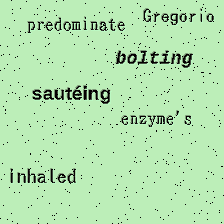

In [7]:
image, _ = generate(224, 224, noise=True)
display_png(image)


学習用に 1000 枚ほど事前に用意しておきます。
画像の縦横サイズは 32 の倍数になるようにしておくと後が楽です。（CNN の構造上 32 の倍数でないと調整が必要になって面倒です。）
今回はそこまでメモリが潤沢な環境ではないので、 224x224 くらいにしておきます。

In [0]:
train_images: List[Image.Image] = []
train_bboxes: List[List[TextBox]] = []
SIZE = 1000
for _ in range(SIZE):
    img, bbs = generate(width=224, height=224)
    train_images.append(img)
    train_bboxes.append(bbs)


## Text Detection

つぎは Text Detection, 文字領域検出に取り掛かります。

### PixelLink

今回は [PixelLink: Detecting Scene Text via Instance Segmentation](https://arxiv.org/abs/1801.01315) [Dan Deng, et al., AAAI 2018. ] を参考にします。
PixelLink は入力画像の各ピクセルについて「そのピクセルが文字領域かどうか」を 0〜1 で予測します。
これだけだと2行の文字領域がつながってしまうので、これを分離するために「そのピクセルが文字領域かどうか」と同時に、各ピクセルについて「8 近傍のピクセルそれぞれと連結しているか（＝同じ文字領域に属しているか）」を 0〜1 で予測します。
最後に、文字領域と予測したピクセルたちに対して、予測した連結情報を基にマージしていき、グループになったピクセル群を囲む四角形を計算します。



### Network Architecture

では実際にネットワークを定義していきます。
入力 *image: H x W x 3* に対して *output: (H / 2) x (W / 2) x 9* の tensor を出力するようにします。
*output[:, :, 0]* が「文字領域かどうか」を表し、*output[:, :, 1:]* が 8 近傍それぞれとの連結状況を表します。
（論文では *(H / 2) x (W / 2) x 18* を出力し、それぞれのサブタスクを表す *(H / 2) x (W / 2) x 2* の tensor について softmax + crossentropy で学習しています。
今回は実装の簡易化とメモリの節約のため、 *(H / 2) x (W / 2) x 1* の tensor で各サブタスクを表し、sigmoid + crossentropy で学習させることにしました。）

PixelLink の論文では VGG16 をベースに U-Net 的な構造を作っていますが、今回はより軽量なモデルである MobileNetV2 を使ってみます。
外形としては PixelLink の論文とほぼ同様です。



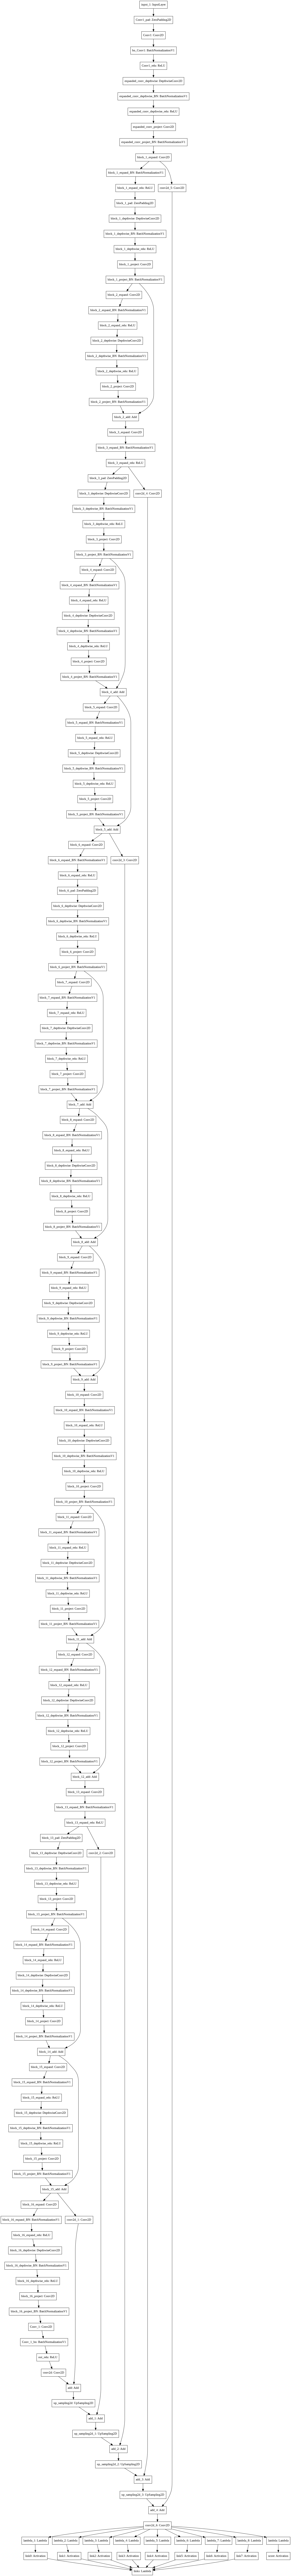

In [9]:
def _fuse_features(filters, x1, x2, upsample=True):
    # type: (int, tf.Tensor, tf.Tensor, bool) -> tf.Tensor
    if upsample:
        x1 = L.UpSampling2D()(x1)
    else:
        x1 = L.Conv2D(filters, 1)(x1)
    x2 = L.Conv2D(filters, 1)(x2)
    return L.add([x1, x2])


def PixelLink(input_shape=(224, 224, 3)):
    # type: (Tuple[Optional[int], Optional[int], int]) -> tf.keras.Model
    mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
    inputs = mobilenetv2.input
    filters = 1 + 8  # pixel score, nerighbor links
    x = _fuse_features(
        filters, mobilenetv2.output, mobilenetv2.get_layer(index=-12).output, upsample=False
    )
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-36).output)
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-101).output)
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-125).output)
    x = _fuse_features(filters, x, mobilenetv2.get_layer(index=-145).output)
    x = L.Conv2D(filters, 1)(x)
    scores = L.Lambda(lambda t: t[..., 0])(x)
    scores = L.Activation("sigmoid", name="score")(scores)
    outputs: List[tf.Tensor] = [scores]
    link_list: List[tf.Tensor] = []
    for i in range(8):
        link = L.Lambda(lambda t: t[..., i + 1])(x)
        link = L.Activation("sigmoid", name="link{}".format(i))(link)
        link_list.append(link)
    links = L.Lambda(lambda t: tf.stack(t, axis=1), name="links")(link_list)
    outputs = [scores, links]
    return tf.keras.Model(inputs, outputs)

detector = PixelLink()
tf.keras.utils.plot_model(detector)

### 学習

ではさきほど作った PixelLink のモデルを、生成したデータセットで学習させてみます。

#### Input Pipeline

まずは入力と正解ラベルを *tf.data.Dataset* として用意します。
Pixel Score の正解ラベルは、多角形の内部を塗りつぶす *cv2.fillPoly* をうまく使うことで簡単に実装できます。
近傍ピクセルとの連結の正解ラベルは、Pixel Score の正解ラベルを 1 ピクセルずらしたものを用意し、Pixel Score との積をとることで、1 ピクセルずらした場所も文字領域であれば 1 、そうでなければ 0 であるような行列が作れます。
また、入力画像は 0〜255 の値をとっていますが、スケールが大きすぎるので -1〜1 の範囲に収まるよう変換しておきます。
最後に、文字領域であるようなピクセルが 1 ピクセルもないような画像を弾いて、ミニバッチにまとめあげれば完了です。
*weights* という tensor については損失関数のところで説明します。



In [0]:

def _detection_data_generator_fn():
    def fn():
        for i in range(SIZE):
            image, boxes = train_images[i], train_bboxes[i]
            points = [
                [[box.xmin, box.ymin], [box.xmin, box.ymax], [box.xmax, box.ymax], [box.xmax, box.ymin]]
                for box in boxes
            ]
            yield np.asarray(image), np.asarray(points)
    return fn


def _generate_pixel_score_and_links(image, points, scale):
    # type: (tf.Tensor, tf.Tensor, int) -> Tupel[tf.Tensor, tf.Tensor]
    """
    Args:
        image: (H, W, 3)
        points: (N, 4, 2)
    Returns:
        score: boolean tensor of shape (H / scale, W / scale).
        links: boolean tensor of shape (8, H / scale, W / scale).
        weights: float32 tensor of shape (H / scale, W / scale).
    """
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    score_height = height // scale
    score_width = width // scale
    score = np.zeros((score_height, score_width), np.uint8)
    sum_area = 0
    weights_map = np.zeros((score_height, score_width), np.float32)
    for pts in points.numpy():
        pts = pts // scale
        score_tmp = np.zeros_like(score)
        # Fill text areas with 1
        cv2.fillPoly(score_tmp, [pts], color=1)
        area = np.sum(score_tmp)
        sum_area += area
        weights_map[score_tmp == 1] = area
        score += score_tmp
    score = np.where(score == 1, score, np.zeros_like(score))
    weights_map = np.where(
        score == 1,
        sum_area / (points.shape[0] + 1e-7) / (weights_map + 1e-7),
        np.zeros_like(weights_map),
    )
    padded_score = np.pad(score, [[1, 1], [1, 1]], "constant")
    links: List[np.ndarray] = []
    for y in range(3):
        for x in range(3):
            if y == 1 and x == 1:
                continue
            tmp = padded_score[y : y + score.shape[0], x : x + score.shape[1]]
            links.append((tmp * score).astype(np.bool))
    return (
        tf.convert_to_tensor(score.astype(np.bool)),
        tf.convert_to_tensor(links),
        tf.convert_to_tensor(weights_map),
    )


def make_detection_dataset(batch_size, scale=2, training=False):
    # type: (int, int, int, int, int, bool) -> tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        _detection_data_generator_fn(),
        output_types=(tf.uint8, tf.int32)
    )
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(batch_size * 10)

    def map_fn(image, points):
        # type: (tf.Tensor, tf.Tensor) -> Tuple[tf.Tensor, Dict[str, tf.Tensor]]
        image = tf.cast(image, tf.float32) / 127.5 - 1  # normalize pixels into -1~1
        score, links, weight = tf.py_function(
            functools.partial(_generate_pixel_score_and_links, scale=scale),
            inp=[image, points],
            Tout=[tf.bool, tf.bool, tf.float32],
        )
        return image, {"score": score, "links": links, "weight": weight}

    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Remove images that have no positive pixels.
    dataset = dataset.filter(lambda image, labels: tf.reduce_sum(labels["weight"]) > 0.0)
    dataset = dataset.batch(batch_size)
    return dataset


#### 損失関数

PixelLink の解こうとしている問題は、すべてピクセル単位のクラス分類なので、損失関数として単純な CrossEntropy をつかえば学習することができます。
しかし、この方法には 2 つの問題があるため、 PixelLink ではもっと複雑な損失関数を提案しています。

- 文字領域に属するピクセル（= Positive Pixel）は、そうでないピクセル（= Negative Pixel）より（大抵の場合）圧倒的に数が少ない
  - 今回はデータを作っているのでここはコントロール可能ですが、一般的には風景画像中の文字領域はすごく狭い
- 大きい文字領域ほど（ピクセル数が多いので）強い影響を持ってしまう
  - ピクセル単位での正解率より、bounding box 単位での正解率をあげたいはず
  - 大きい文字領域が強い影響をもつと、小さい bounding box は軽視され、結果的にピクセル単位での正解率より bounding box 単位での正解率が悪くなる

PixelLink ではこの問題は次のような工夫で解消しようとしています。

- Online Hard Negative Mining
  - Negative Pixel のうち、損失が大きい方から (Positive Pixel の数) x 3x ピクセルだけを最終的な損失に加算する
  - より判断が難しい Negative Pixel を適切に判断することに集中させる
- 文字領域ごとに、内包するピクセルの「損失への寄与度」を「その文字領域の面積の逆数」で重み付けする
  - 大きい文字領域ほど、個々のピクセルの寄与度を小さくする
  - 文字領域全体で even になる
  - これを計算しているのがさきほど説明を省略した *weights* という tensor です

コードは次のようになります。（この部分、それなりに複雑なので解釈・実装が間違っている可能性があります。何かに使う場合は必ず論文や参照実装をご確認ください。）


In [0]:
def loss_fn(score_true, score_pred, links_true, links_pred, weights, r=3):
    # type: (tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, int) -> (tf.Tensor, tf.Tensor)
    batch = tf.shape(score_true)[0]
    n_pixels = tf.shape(score_true)[1] * tf.shape(score_pred)[2]
    score_true = tf.reshape(score_true, (batch, n_pixels, 1))
    score_pred = tf.reshape(score_pred, (batch, n_pixels, 1))
    links_true = tf.reshape(links_true, (batch, 8, n_pixels, 1))
    links_pred = tf.reshape(links_pred, (batch, 8, n_pixels, 1))
    weights = tf.reshape(weights, (batch, n_pixels))
    positive_mask = tf.cast(weights > 0.0, tf.int32)
    n_positive_pixels = tf.reduce_sum(positive_mask, axis=1)
    negative_mask = 1 - positive_mask

    # ==== Select hard negative examples
    score_ce = tf.keras.losses.binary_crossentropy(score_true, score_pred)
    n_hard_examples = tf.minimum(n_positive_pixels * r, n_pixels - n_positive_pixels)
    negative_score_ce = score_ce * tf.cast(negative_mask, tf.float32)
    # 損失が大きい順に並び替え、（3 x positive pixel の数）位の値を threshold とします
    sorted_negative_ce = tf.sort(negative_score_ce, axis=-1, direction="DESCENDING")
    hard_negative_threshold = tf.map_fn(
        lambda args: args[1][args[0]],
        elems=[n_hard_examples, sorted_negative_ce],
        dtype=tf.float32,
    )
    hard_negative_mask = negative_score_ce >= hard_negative_threshold[:, tf.newaxis]
    weights = tf.where(hard_negative_mask, tf.ones_like(weights), weights)
    # === Score Loss
    score_loss = tf.reduce_sum(
        1.0
        / (
            ((1.0 + float(r)) * tf.cast(n_positive_pixels[:, tf.newaxis], tf.float32))
            + 1e-7
        )
        * weights
        * score_ce
    )
    # === Link Loss
    links_ce = tf.keras.losses.binary_crossentropy(links_true, links_pred)
    weights_pos_links = weights[:, tf.newaxis, :, tf.newaxis] * tf.cast(links_true, tf.float32)
    weights_neg_links = weights[:, tf.newaxis, :, tf.newaxis] * (
        1.0 - tf.cast(links_true, tf.float32)
    )
    links_pos_ce = links_ce[:, :, :, tf.newaxis] * weights_pos_links
    links_neg_ce = links_ce[:, :, :, tf.newaxis] * weights_neg_links
    links_loss = tf.reduce_sum(
        links_pos_ce
        / (
            tf.reduce_sum(weights_pos_links, axis=(1, 2))[:, tf.newaxis, tf.newaxis]
            + 1e-7
        )
        + links_neg_ce
        / (
            tf.reduce_sum(weights_neg_links, axis=(1, 2))[:, tf.newaxis, tf.newaxis]
            + 1e-7,
        )
    )
    return score_loss, links_loss


#### Training Loop

学習部分は単純で、用意した Dataset をネットワークと損失関数に流すだけです。
Metrics として AUC を記録するようにしています。
本当は validation set を用意すべきですが、どうせ生成データなのでスキップします。


In [12]:
detector = PixelLink()
optimizer = tf.keras.optimizers.Adam()
BATCH_SIZE = 8

metrics = {
    "loss": tf.keras.metrics.Mean(name="loss"),
    "pixel/auc": tf.keras.metrics.AUC(name="pixel/auc"),
    "link/auc": tf.keras.metrics.AUC(name="link/aux"),
}


def get_loss(images, labels):
    score_pred, link_pred = detector(images)
    score_loss, link_loss = loss_fn(
        labels["score"], score_pred, labels["links"], link_pred, labels["weight"]
    )
    loss = score_loss + 2.0 * link_loss
    metrics["loss"](loss)
    metrics["pixel/auc"](labels["score"], score_pred)
    metrics["link/auc"](labels["links"], link_pred)
    return loss


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        loss = get_loss(images, labels)
    gradients = tape.gradient(loss, detector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, detector.trainable_variables))


def train():
    dataset = make_detection_dataset(BATCH_SIZE)
    for images, labels in dataset:
        images.set_shape((None, None, None, 3))
        with tf.GradientTape() as tape:
            loss = get_loss(images, labels)
        gradients = tape.gradient(loss, detector.trainable_variables)
        optimizer.apply_gradients(zip(gradients, detector.trainable_variables))


for epoch in range(50):
    print("Epoch {}".format(epoch))
    train()
    for k, m in metrics.items():
        tf.print("Step", optimizer.iterations, ":", k, ":", m.result())


W0414 12:24:51.910595 140221436852096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:410: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Epoch 0
Step 125 : loss : 15.6597776
Step 125 : pixel/auc : 0.857405722
Step 125 : link/auc : 0.913708627
Epoch 1
Step 250 : loss : 11.9480877
Step 250 : pixel/auc : 0.939428091
Step 250 : link/auc : 0.955817
Epoch 2
Step 375 : loss : 10.1674633
Step 375 : pixel/auc : 0.961746335
Step 375 : link/auc : 0.969623923
Epoch 3
Step 500 : loss : 9.14073849
Step 500 : pixel/auc : 0.971677959
Step 500 : link/auc : 0.976212621
Epoch 4
Step 625 : loss : 8.43804264
Step 625 : pixel/auc : 0.977264822
Step 625 : link/auc : 0.980122745
Epoch 5
Step 750 : loss : 7.92087889
Step 750 : pixel/auc : 0.980823696
Step 750 : link/auc : 0.982699215
Epoch 6
Step 875 : loss : 7.526721
Step 875 : pixel/auc : 0.983261406
Step 875 : link/auc : 0.98450017
Epoch 7
Step 1000 : loss : 7.21588373
Step 1000 : pixel/auc : 0.985026538
Step 1000 : link/auc : 0.985824645
Epoch 8
Step 1125 : loss : 6.96274567
Step 1125 : pixel/auc : 0.986366093
Step 1125 : link/auc : 0.986843109
Epoch 9
Step 1250 : loss : 6.75381088
Step 125

@*tf.function* は TensorFlow 2.0 から導入されるもので、Eager Mode がデフォルトになった TensorFlow の世界から、より効率のよい Graph Mode への橋渡しをしてくれるデコレータです。
これをつけるだけで 1.5〜2 倍ほど速くなるので便利です。


#### Run Detector

では学習したモデルを使って実際に文字領域の bounding box を予測・可視化してみます。

 1. 画像をモデルに入力し、文字領域と連結状況の推論結果を得る。
 2. 文字領域であると予測した全ピクセルについて、近傍ピクセルとの連結をとってグループにまとめていく。 近傍ピクセルの連結には Union Find を使う。
 3. それぞれのグループについて、 *cv2.minAreaRect* でグループ全体を覆う最小の bounding box を計算する。

という工程で bounding box が得られます。
実際のコードは次のようになります。


In [0]:
def _link_pixels(pixel_mask: np.ndarray, link_mask: np.ndarray) -> np.ndarray:
    """Link positive pixels.
    Args:
        pixel_mask: uint8 array of shape [H, W]
        link_mask: uint8 array of shape [8, H, W]
    Returns:
        link_map: int array of shape [H, W]. If the pixel (x, y)
                  is linked to i-th group, link_map[y, x] = i.
    """
    union_find: Dict[Tuple[int, int], Tuple[int, int]] = {}

    def find_root(p):
        if union_find.get(p, p) == p:
            union_find[p] = p
            return p
        root = find_root(union_find[p])
        union_find[p] = root
        return root

    def link(p1, p2):
        root1 = find_root(p1)
        root2 = find_root(p2)
        if root1 != root2:
            union_find[root1] = root2

    def neighbors(y, x):
        return [
            (y - 1, x - 1),
            (y - 1, x),
            (y - 1, x + 1),
            (y, x - 1),
            (y, x + 1),
            (y + 1, x - 1),
            (y + 1, x),
            (y + 1, x + 1),
        ]

    def is_valid_coor(y, x, h, w):
        return 0 <= y < h and 0 <= x < w

    mask_height, mask_width = pixel_mask.shape
    points = list(zip(*np.where(pixel_mask)))  # points of text area
    for point in points:
        y, x = point
        for i, (y_, x_) in enumerate(neighbors(y, x)):
            if (               is_valid_coor(y_, x_, mask_height, mask_width)
                and link_mask[i, y_, x_] == 1
            ):
                link(point, (y_, x_))

    res = np.zeros((mask_height, mask_width), np.int32)
    roots = {}
    for point in points:
        y, x = point
        root = find_root(point)
        root_index = roots.get(root, None)
        if root_index is None:
            root_index = len(roots) + 1
            roots[root] = root_index
        res[y, x] = root_index
    return res


def mask_to_instance_map(
    score: np.ndarray,
    link: np.ndarray,
    score_thres: float = 0.8,
    link_thres: float = 0.7,
) -> np.ndarray:
    height, width = score.shape[0], score.shape[1]
    pixel_mask = score[:, :] > score_thres
    link_neighbors = np.zeros((8, height, width), dtype=np.uint8)
    link_neighbors = link > link_thres
    link_neighbors = link_neighbors * pixel_mask[np.newaxis, :, :].astype(np.uint8)
    return _link_pixels(pixel_mask, link_neighbors)


def instance_map_to_bbox(
    instance_map: np.ndarray, scale: int, n_points_thres: int = 10
) -> np.ndarray:
    """Convert instance_map into bbox coordinates list.

    Args:
        instance_map: result of mask_to_instance_map.
        scale: feature map scale.
        n_points_thres: instances those points are less than n_points_thres will be removed.
    Returns:
        bboxes: np.ndarray of shape [N, 4, 2 (x, y)]
    """
    map_height, map_width = instance_map.shape[0], instance_map.shape[1]
    area = map_height * map_width
    bboxes: List[List[np.ndarray]] = []
    num_bboxes = np.max(instance_map)
    for n in range(1, num_bboxes + 1):
        points = np.array(list(zip(*np.where(instance_map == n))))
        n_points = points.shape[0]
        if n_points < n_points_thres:
            continue
        rect = cv2.minAreaRect(points)
        bbox = cv2.boxPoints(rect)
        bbox[:, 0] = np.clip(bbox[:, 0], 0, map_height)
        bbox[:, 1] = np.clip(bbox[:, 1], 0, map_width)
        bboxes.append(bbox[:, [1, 0]])
    bboxes_ndarray = np.asarray(bboxes)
    return (bboxes_ndarray * scale).astype(np.int32)


def predict_bboxes(image: np.ndarray, model: tf.keras.Model):
    input = (image.astype(np.float32) / 127.5 - 1)[np.newaxis, ...]
    scores, links = model.predict(input)
    instance_map = mask_to_instance_map(scores[0], links[0])
    return instance_map_to_bbox(instance_map, scale=2)


可視化してみるとこんな感じになります。

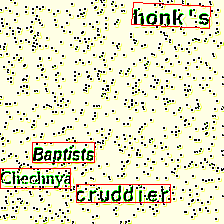

In [14]:
target_image = np.asarray(generate(224, 224)[0])
bboxes = predict_bboxes(target_image, detector)
for bbox in bboxes:
    cv2.drawContours(target_image, [bbox], 0, (255, 0, 0), 1)
display_png(Image.fromarray(target_image))


重みを Google Drive  に保存してお掃除しておきます。


In [0]:
detector.save_weights(os.path.join(rootdir, "detector_weights.h5"))
del detector

## Text Recognition

Detection の次は Recognition です。 Recognition の責務は「切り取られた文字領域が与えられた時、そこに書かれている文字を予測する」ことでした。 今回は入力画像の高さを 32px で揃えることにします。
32×200 とか 32×600 といった横長の画像を受け取って、「あいう」といった文字列を返すことが目標です。

Recognition の概要は次のようになります。

![recognizer abst](https://github.com/agatan/Building-OCR-System-TechBookFest6/raw/master/images/recognizer-abst.png)


二次元画像 *H x W x 3* を適当な CNN に通しつつ、縦方向に pooling（or strided conv）することで *(W / 4) x C* に変換します。
ここで、C は「扱いたい文字種の数 + 2 (unknown と blank)」です。
出力された *(W / 4) x C* の行列は、C 方向について softmax をとることで、「横方向の各ピクセルがその文字種である確率を表す行列」とみなすことができます。


あとは CrossEntropy を損失に学習すればよい、と言いたいところですが、今回ももう少し問題は複雑です。
「横方向の各ピクセルがその文字種である確率」を予測したとしても、通常「横方向の各ピクセルがなんという文字に所属しているか」という正解データはありません。
もちろん頑張れば作れますが、「何という文字が書いてあるか」だけを集めるのに比べてコストが非常に高くなります。


そこで CTC Loss [^8] を採用します。
CTC は、セグメントに分割されていない系列データをうまく扱うための枠組みで、音声認識などにも活用されています。
セグメントに分割されていない系列データとは、「どこからどこまでが a で、どこからどこまでが b なのか」というラベルがなく、a のあとに b がくる、ということだけがわかっている状態です。

CTC の世界では連続する同一ラベルは一つにマージされます。たとえば *aaab* や *abbb* は *ab* とデコードされます。
また、正解ラベルが *aaa* のように同じ文字が連続するケースに備えて、 *-* (blank) 記号を用意しておきます。
*-* は基本的には無にデコードされますが、セパレータの役割も担っており同一ラベルであっても *-* をはさめばマージされなくなります。
たとえば *a-aa-b* や *aa-aab* は *aab* にデコードされます。
ここで、 *a-aa-b* や *aa-aab* のようなラベルの列を *パス* と呼びます。

あるパスが選択される確率は、各ラベルの確率の積です。
正解ラベル *aab* を当てられる確率は、 「*aab* にデコードされるすべてのパスの確率」の総和で表すことができます。
CTC によって「正解ラベルにデコードされるようなすべてのパスの確率を最大化する」ように学習することで、セグメント情報がない系列データに対してもうまく学習することができるようになります。

[^8]: [Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks. A Graves, et al., In ICML.

全体像を説明したところで、まずはモデルの定義からはじめます。

### Network Architecture

Recognizer は、入力画像を Convolution などに通しつつ縦方向につぶしていきます。
入力画像のサイズは小さい（高さ 32 ピクセルにそろえている）ので、小さいモデルをベースに組み立てれば良いでしょう。
今回は ResNet-18 をベースにしたネットワークを組みます。
ResNet-18 は *tf.keras.applications* にもないですし、通常 2x2 で pooling するところを 2x1 で pooling するように変更する必要もあるので、自前で実装します。
（https://github.com/raghakot/keras-resnet を参考にさせていただきました）

縦方向につぶした後、LSTM に通す場合もあるようですが、RNN は CNN に比べて遅いこと、そこまで大きい精度向上が期待できなかったことなどから CNN のみで構成しています。

重要なのは、最終的な出力の shape *W x C* の C の値です。
さきほど説明した CTC のために blank 記号を用意する必要があります。そこで、「扱いたい文字種 + Unknown + blank」を C として設定しています。

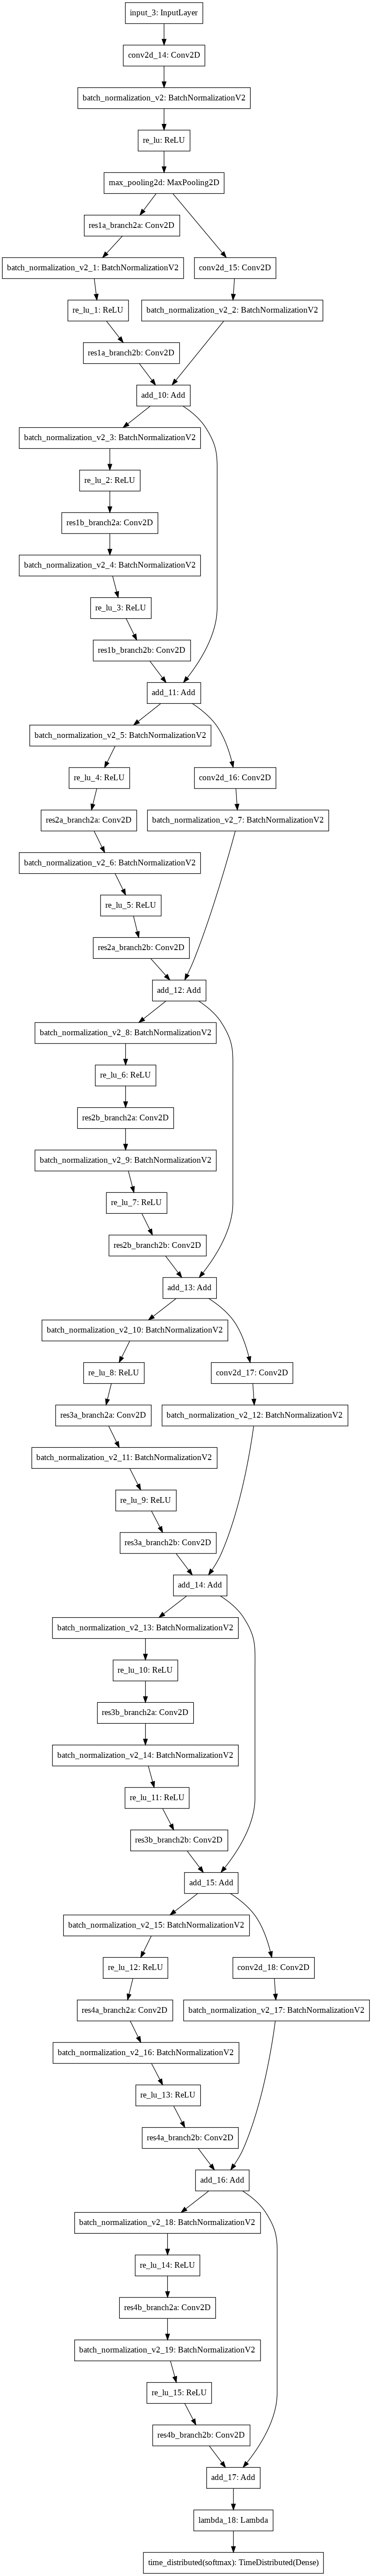

In [16]:
def _bn_relu(x):
    x = L.BatchNormalization()(x)
    return L.ReLU()(x)


def _conv_bn_relu(x, filters, kernel_size, conv_name=None, **conv_params):
    conv_params.setdefault("strides", (1, 1))
    conv_params.setdefault("dilation_rate", (1, 1))
    conv_params.setdefault("kernel_initializer", "he_normal")
    conv_params.setdefault("padding", "same")
    conv_params.setdefault("kernel_regularizer", tf.keras.regularizers.l2(1.0e-4))
    x = L.Conv2D(filters, kernel_size, name=conv_name, **conv_params)(x)
    return _bn_relu(x)


def _bn_relu_conv(x, filters, kernel_size, conv_name=None, **conv_params):
    conv_params.setdefault("strides", (1, 1))
    conv_params.setdefault("dilation_rate", (1, 1))
    conv_params.setdefault("kernel_initializer", "he_normal")
    conv_params.setdefault("padding", "same")
    conv_params.setdefault("kernel_regularizer", tf.keras.regularizers.l2(1.0e-4))
    x = _bn_relu(x)
    x = L.Conv2D(filters, kernel_size, name=conv_name, **conv_params)(x)
    return x

def _shortcut(
    input_feature,
    residual,
    stride_width,
    stride_height,
    conv_name_base=None,
    bn_name_base=None,
):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = input_feature.shape.as_list()
    residual_shape = residual.shape.as_list()

    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        if conv_name_base is not None:
            conv_name_base = conv_name_base + "1"
        shortcut = L.Conv2D(
            filters=residual_shape[3],
            kernel_size=(1, 1),
            strides=(stride_height, stride_width),
            padding="valid",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            name=conv_name_base,
        )(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + "1"
        shortcut = L.BatchNormalization(name=bn_name_base)(shortcut)
    return L.add([shortcut, residual])


def _basic_block(
    input_feature,
    filters,
    stage,
    block,
    transition_strides=(1, 1),
    dilation_rate=(1, 1),
    is_first_block_of_first_layer=False,
):
    if block < 27:
        block = "%c" % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = "res" + str(stage) + block + "_branch"
    x = input_feature
    if is_first_block_of_first_layer:
        x = L.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            strides=transition_strides,
            dilation_rate=dilation_rate,
            padding="same",
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
            name=conv_name_base + "2a",
        )(x)
    else:
        x = _bn_relu_conv(
            x,
            filters=filters,
            kernel_size=(3, 3),
            strides=transition_strides,
            dilation_rate=dilation_rate,
            conv_name=conv_name_base + "2a",
        )
    x = _bn_relu_conv(
        x,
        filters=filters,
        kernel_size=(3, 3),
        conv_name=conv_name_base + "2b",
    )
    return _shortcut(
        input_feature,
        x,
        stride_width=transition_strides[1],
        stride_height=transition_strides[0],
    )


def _residual_block(
    x,
    filters,
    stage,
    blocks,
    is_first_layer,
    transition_dilation_rates,
    transition_strides,
):
    for i in range(blocks):
        x = _basic_block(
            x,
            filters=filters,
            stage=stage,
            block=i,
            transition_strides=transition_strides[i],
            dilation_rate=transition_dilation_rates[i],
            is_first_block_of_first_layer=(is_first_layer and i == 0),
        )
    return x


def create_recognition_model(input_shape, n_vocab):
    input = tf.keras.layers.Input(shape=input_shape)
    x = _conv_bn_relu(
        input, filters=64, kernel_size=(7, 7), strides=(2, 2)
    )
    x = L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)
    x = _residual_block(
        x,
        128,
        stage=1,
        blocks=2,
        is_first_layer=True,
        transition_strides=[(1, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = _residual_block(
        x,
        256,
        stage=2,
        blocks=2,
        is_first_layer=False,
        transition_strides=[(2, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = _residual_block(
        x,
        512,
        stage=3,
        blocks=2,
        is_first_layer=False,
        transition_strides=[(2, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = _residual_block(
        x,
        1024,
        stage=4,
        blocks=2,
        is_first_layer=False,
        transition_strides=[(2, 1), (1, 1)],
        transition_dilation_rates=[1, 1],
    )
    x = L.Lambda(lambda fm: tf.squeeze(fm, axis=1))(x)
    x = L.TimeDistributed(L.Dense(n_vocab + 1, activation="softmax", name="softmax"))(x)
    return tf.keras.Model(input, x)


CHARACTERS = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!#$%&()*+-./:<=>?@[\]^_{}~'")
# 未知の文字が来た場合 unknown というラベルにしたいので +1
n_vocab = len(CHARACTERS) + 1
recognizer = create_recognition_model(input_shape=(32, None, 3), n_vocab=n_vocab)
tf.keras.utils.plot_model(recognizer)


### 学習

#### Input Pipeline

さきほど生成しておいた画像たちを Recognition の学習にも流用します。
生成されたのは複数の文字領域を含む画像だったので、文字領域ごとに切り出していきます。
CTC Loss を計算するために「文字数」「画像の横幅」も必要になるので合わせて用意します。

切り出す際には、座標をちょっとだけランダムに揺らして切り出しています。
Detector が多少間違った bounding box を予測したとしても、うまく文字認識できるようにするためです。

また、各画像をまとめるために *tf.data.Dataset.padded_batch* を使っています。
バッチにはいろんな長さの文字列、画像が含まれるので、shape の大きいものに揃えた上で 0 で padding します。

学習を高速化・安定化させるために、縦横比が一定以上（横に長過ぎる、縦に長過ぎる）ものは弾いています。


In [0]:

RECOGNITION_HEIGHT = 32
# 0 is for UNKNOWN.
CHAR_MAP = {c: i + 1 for i, c in enumerate(CHARACTERS)}

from concurrent.futures import ProcessPoolExecutor

def _recognition_generator_map_fn(args):
    image, bboxes = args
    img = np.asarray(image)
    results = []
    for bbox in bboxes:
        height = bbox.ymax - bbox.ymin
        ymin = int(round(max(0, bbox.ymin - np.random.random() * height / 10)))
        xmin = int(round(max(0, bbox.xmin - np.random.random() * height / 10)))
        ymax = int(round(min(img.shape[0], bbox.ymax + np.random.random() * height / 10)))
        xmax = int(round(min(img.shape[1], bbox.xmax + np.random.random() * height / 10)))
        cropped = img[ymin:ymax, xmin:xmax]
        h, w = cropped.shape[0], cropped.shape[1]
        resized = cv2.resize(cropped, (int(w * RECOGNITION_HEIGHT / h), RECOGNITION_HEIGHT))
        resized_width = resized.shape[1]
        text_length = len(bbox.text)
        if resized_width // 4 < text_length:
            continue
        if resized_width > 32 * 4:
            # To stabilize training, refuse to use too long images.
            continue
        text = [CHAR_MAP.get(c, 0) for c in bbox.text]
        results.append((resized, {"width": resized_width, "text": text, "text_length": text_length}))
    return results


# 遅いので事前計算
recognition_examples = []
with ProcessPoolExecutor() as pool:
    for examples in pool.map(_recognition_generator_map_fn, zip(train_images, train_bboxes)):
        recognition_examples.extend(examples)


def recognition_data_generator_fn():
    def fn():
        for example in recognition_examples:
            yield example
    return fn


def make_recognition_dataset(batch_size, training=False):
    dataset = tf.data.Dataset.from_generator(
        recognition_data_generator_fn(),
        output_types=(tf.uint8, {"width": tf.int32, "text": tf.int32, "text_length": tf.int32})
    )
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    if training:
        dataset = dataset.shuffle()
    dataset = dataset.padded_batch(
        batch_size,
        padded_shapes=((32, None, 3), {"width": (), "text": (None,), "text_length": ()}),
    )
    def map_fn(image, labels):
        return tf.cast(image, tf.float32) / 127.5 -1, labels
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


#### 損失関数

先に述べたように損失関数は CTC Loss を使います。
Keras が用意している関数をそのまま使えるので簡単です。



In [0]:
@tf.function(input_signature=(
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32),
))
def recognition_loss(y_pred, y_true, input_width, text_length):
    pred_length = input_width // 4
    cost = tf.keras.backend.ctc_batch_cost(y_true, y_pred, pred_length[..., tf.newaxis], text_length[..., tf.newaxis])
    return tf.reduce_mean(cost)


#### Training Loop

学習部分もふつうにやるだけです。
が、optimizer の学習率は小さい値にしないと学習がまったく進まない・安定しないので注意してください。
ここではデフォルトの 0.001 から 0.0001 に変更しています。


In [19]:
recognizer = create_recognition_model(input_shape=(RECOGNITION_HEIGHT, None, 3), n_vocab=len(CHARACTERS) + 1)
optimizer = tf.keras.optimizers.Adam(1e-4)
losses = tf.keras.metrics.Mean(name="reconition/loss")

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        y_pred = recognizer(images, training=True)
        loss = recognition_loss(y_pred, labels["text"], labels["width"], labels["text_length"])
    losses(loss)
    gradients = tape.gradient(loss, recognizer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, recognizer.trainable_variables))


def train(dataset):
    for images, labels in dataset:
        train_step(images, labels)
        if tf.equal(optimizer.iterations % 10, 0):
            tf.print("Step", optimizer.iterations, ": Loss :", losses.result())


dataset = make_recognition_dataset(32)
for epoch in range(50):
    print("Epoch {}".format(epoch))
    train(dataset)
    tf.print("Step", optimizer.iterations, ": Loss :", losses.result())

recognizer.save_weights(os.path.join(rootdir, "recognizer_weights.h5"))

Epoch 0


W0414 13:25:43.851502 140221436852096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:5151: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0414 13:25:44.017130 140221436852096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:5130: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Step 10 : Loss : 45.4808
Step 20 : Loss : 36.0753555
Step 30 : Loss : 30.78442
Step 40 : Loss : 27.4784451
Step 50 : Loss : 25.0855198
Step 60 : Loss : 23.0488796
Step 70 : Loss : 21.3925762
Step 80 : Loss : 20.0265503
Step 87 : Loss : 19.169548
Epoch 1
Step 90 : Loss : 18.794651
Step 100 : Loss : 17.6907978
Step 110 : Loss : 16.6733093
Step 120 : Loss : 15.7363644
Step 130 : Loss : 14.9411879
Step 140 : Loss : 14.2243137
Step 150 : Loss : 13.5221052
Step 160 : Loss : 12.8826008
Step 170 : Loss : 12.3169651
Step 174 : Loss : 12.0740213
Epoch 2
Step 180 : Loss : 11.7507648
Step 190 : Loss : 11.23598
Step 200 : Loss : 10.7679396
Step 210 : Loss : 10.3242207
Step 220 : Loss : 9.91886616
Step 230 : Loss : 9.53665066
Step 240 : Loss : 9.18475
Step 250 : Loss : 8.8542
Step 260 : Loss : 8.5509882
Step 261 : Loss : 8.51878
Epoch 3
Step 270 : Loss : 8.26256943
Step 280 : Loss : 7.99825
Step 290 : Loss : 7.74290228
Step 300 : Loss : 7.50333261
Step 310 : Loss : 7.27495909
Step 320 : Loss : 7.058

#### Run Recognizer

Recognizer は Detector とちがって複雑な後処理もなくシンプルです。
Keras の用意している *tf.keras.backend.ctc_decode* をそのまま使います。


In [0]:
def predict_text(image: np.ndarray, model: tf.keras.Model) -> str:
    height = image.shape[0]
    image = cv2.resize(image, (int(image.shape[1] / height * RECOGNITION_HEIGHT), RECOGNITION_HEIGHT))
    input = (image.astype(np.float32) / 127.5 - 1.0)[np.newaxis, :, :, :]
    pred = model.predict(input)
    decoded, _ = tf.keras.backend.ctc_decode(pred, [input.shape[2] // 4])
    return "".join((CHARACTERS[idx - 1] for idx in decoded[0][0].numpy()))


## Detector と Recognizer をつなぐ

これでパーツは揃いました。
最後に2つをつなぎこんであげれば、ドキュメント画像から文字を読み取るシステムの完成です。

W0414 14:22:36.136659 140221436852096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:5207: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


wessel
hieriness
lukes
hguratiuve
scn
hordliner's
overthro's


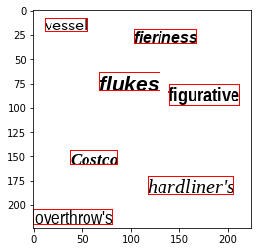

In [22]:
detector = PixelLink()
detector.load_weights(os.path.join(rootdir, "detector_weights.h5"))
recognizer = create_recognition_model(input_shape=(RECOGNITION_HEIGHT, None, 3), n_vocab=len(CHARACTERS) + 1)
recognizer.load_weights(os.path.join(rootdir, "recognizer_weights.h5"))

image = np.asarray(generate(224, 224, noise=False)[0])
bboxes = predict_bboxes(image, detector)
for bbox in bboxes:
    xmin = np.min(bbox[:, 0])
    ymin = np.min(bbox[:, 1])
    xmax = np.max(bbox[:, 0])
    ymax = np.max(bbox[:, 1])
    crop = image[ymin:ymax, xmin:xmax]
    text = predict_text(crop, recognizer)
    cv2.drawContours(image, [bbox], 0, (255, 0, 0), 1)
    print(text)
plt.imshow(image)

## おわりに

というわけで駆け足に Text Detection と Text Recognition を実装してみました。
今回は Colaboratory で完結させるためにデータ量、学習時間ともに少なくしたうえ、数字・アルファベット・記号のみを認識するようにしていますが、同じ枠組みで文字種を増やしデータをちゃんとしたものに差し替えれば十分に機能する文書読み取りエンジンになります。
実際に使うにはもっといろいろな工夫が必要ですが、ベースとなるネットワーク構造や学習の仕組みは記述できたのではないかと思っています。
もし間違っている箇所に気づいた方は教えていただけると幸いです。

<s>本当はこのあと Web カメラにつないだり TensorFlow Lite を使って Android アプリケーションにしたりという夢を膨らませていましたが力尽きました</s>

Wantedly People  機械学習チームでは、このような文書読み取りエンジンだけでなく、「お知り合いですか？」のユーザ推薦や、名刺と会社情報のマッチング、名刺に関連するニュースの推薦などなどを扱っています。
毎週きまった時間に、最近読んだ論文や面白いと思った技術について語り合う勉強会をやることで、最新の技術や自分の知らない技術領域のキャッチアップをしつつ業務に活かしています。
メンバーは2,3人ですが、画像, 自然言語, ソーシャルグラフと幅広いジャンルを扱っていて面白いですし、深い専門知識のある方のツッコミにも飢えていますので、もし興味があったら [@agatan_](https://twitter.com/agatan_) にご連絡ください！
